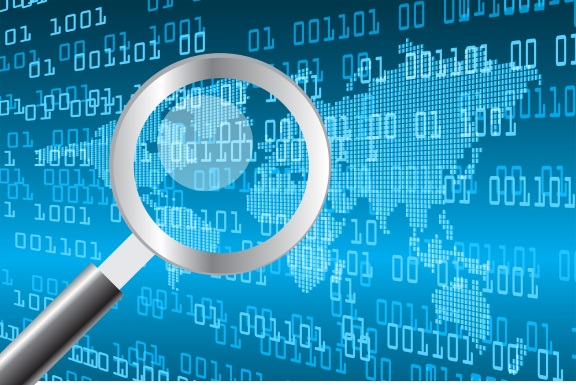

## Introduction
* Using the info set from: https://u.cs.biu.ac.il/~koppel/BlogCorpus.htm you shall build an enquiry and ranking system for taking a question as input and retrieving all the blogs that contain the terms and also are ranked.
* The query are provided as an English query joined does on google search.
* The query could contain sentence/keyword/phrases query.
* Do confine mind, the queries may not contain the precise words as presented within the blogs, so please make sure that relevant words and similar word matches are taken into consideration.

## Semantic Search

At first, search engines were lexical: the search engine looked for literal matches of the query words, without understanding of the query’s meaning and only returning links that contained the exact query.By using regular keyword search, a document either contains the given word or not, and there is no middle ground

On the other hand, "Semantic Search" can simplify query building, becuase it is supported by automated natural language processing programs i.e. using Latent Semantic Indexing - a concept that search engines use to discover how a keyword and content work together to mean the same thing.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import spacy
import string
import gensim
import operator
import re

### Load the data
We will now load the blogs data csv into dataframe and quickly peek into the columns and data provided

In [2]:
df_blogs = pd.read_csv('/kaggle/input/blog-authorship-corpus/blogtext.csv')
df_blogs.head()
df_blog =df_blogs.head(1000)

In [3]:
df_blogs.head(1000)


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
...,...,...,...,...,...,...,...
995,4313749,female,25,indUnk,Taurus,"22,August,2004",urlLink Me. A doggy bed. Need I...
996,4313749,female,25,indUnk,Taurus,"22,August,2004","Ah yes, the summer Olympics are no..."
997,3827097,female,15,Arts,Pisces,"06,July,2004",Current Music: Could It Be Magic - Do...
998,3827097,female,15,Arts,Pisces,"02,July,2004",Hey. This one of the many things I have...


### Data Cleaning and Pre-processing
Data pre-processing is one of the most significant step in text analytics. The purpose is to remove any unwanted words or characters which are written for human readability, but won't contribute to topic modelling in anyway.

The following function applies regular expression for matching patterns of unwanted text and removing/replacing them.


In [4]:


from spacy.lang.en.stop_words import STOP_WORDS
spacy.prefer_gpu()
spacy_nlp = spacy.load('en_core_web_sm')

#create list of punctuations and stopwords
punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
from nltk.tokenize import word_tokenize


def spacy_tokenizer(sentence):
 
    #remove distracting single quotes
    sentence = re.sub('\'','',sentence)

#     #remove digits adnd words containing digits
    sentence = re.sub('\w*\d\w*','',sentence)

#     #replace extra spaces with single space
    sentence = re.sub(' +',' ',sentence)

#     #remove unwanted lines starting from special charcters
    sentence = re.sub(r'\n: \'\'.*','',sentence)
    sentence = re.sub(r'\n!.*','',sentence)
    sentence = re.sub(r'^:\'\'.*','',sentence)
    
#     #remove non-breaking new line characters
    sentence = re.sub(r'\n',' ',sentence)
    
#     #remove punctunations
    sentence = re.sub(r'[^\w\s]',' ',sentence)

#     #creating token object
    tokens = spacy_nlp(sentence)
    
    #lower, strip and lemmatize
    tokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens]
    
    #remove stopwords, and exclude words less than 2 characters
    tokens = [word for word in tokens if word not in stop_words and word not in punctuations and len(word) > 2]
    
    #return tokens
    return tokens


Now let us apply the data-cleaning and pre-processing function to our blogs "wiki_plot" column and store the cleaned, tokenized data into new column

In [5]:
print ('Cleaning and Tokenizing...')


%time df_blog['text_tokenized'] = df_blog['text'].map(lambda x: spacy_tokenizer(x))


Cleaning and Tokenizing...
CPU times: user 36.4 s, sys: 116 ms, total: 36.5 s
Wall time: 36.9 s


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Store the tokenized column into a sepearte variable for ease of operations in subsequent sections and have a quick peek into the values

In [6]:
df_blog = df_blog['text_tokenized']
df_blog[0:5]

0    [info, find, page, pdf, file, wait, untill, te...
1    [team, member, drewes, van, der, laag, urllink...
2    [het, kader, van, kernfusie, aarde, maak, eige...
3                                   [testing, testing]
4    [thank, yahoo, toolbar, capture, url, popup, m...
Name: text_tokenized, dtype: object

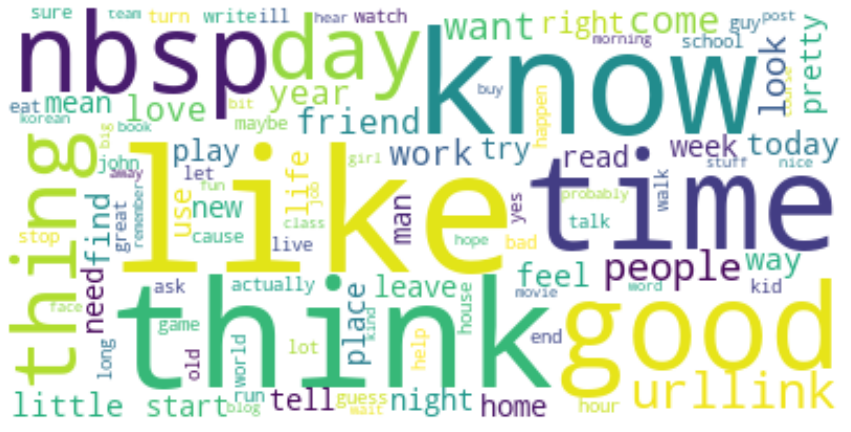

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

series = pd.Series(np.concatenate(df_blog)).value_counts()[:100]
wordcloud = WordCloud(background_color='white').generate_from_frequencies(series)

plt.figure(figsize=(15,15), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Building Word Dictionary

In the next step we will build the vocabulary of the corpus in which all the unique words are given IDs and their frequency counds are also stored. You may note that we are using gensim library for building the dictionary.   In gensim, the words are referred as "tokens" adn the index of each word in the dictionary is called ID

In [8]:
from gensim import corpora
from nltk.corpus import stopwords
# #creating term dictionary
%time dictionary = corpora.Dictionary(df_blog)
stoplist = set('')
stop_ids = [dictionary.token2id[stopword] for stopword in stoplist if stopword in dictionary.token2id]
dictionary.filter_tokens(stop_ids)




CPU times: user 164 ms, sys: 1.97 ms, total: 166 ms
Wall time: 167 ms


You can see that there are 2 additional steps performed after creating the dictionary.
1. All the tokens in the dictionary which either have occurrred in less than 4 articles or have occurred in more than 20% of the articles are removed from the dictionary, as these words will not be contributing to the various themes or topics. 
2. Removing content neutral words from the dictionary and additional stopwords.

In [9]:
#print top 50 items from the dictionary with their unique token-id
dict_tokens = [[[dictionary[key], dictionary.token2id[dictionary[key]]] for key, value in dictionary.items() if key <= 50]]
print (dict_tokens)

[[['file', 0], ['find', 1], ['html', 2], ['info', 3], ['leader', 4], ['learn', 5], ['page', 6], ['pdf', 7], ['process', 8], ['team', 9], ['untill', 10], ['wait', 11], ['aaldering', 12], ['bryan', 13], ['der', 14], ['drewes', 15], ['laag', 16], ['mail', 17], ['member', 18], ['ruiyu', 19], ['urllink', 20], ['van', 21], ['xie', 22], ['aarde', 23], ['able', 24], ['absolutely', 25], ['accidentally', 26], ['accomplish', 27], ['accord', 28], ['accuracy', 29], ['accuse', 30], ['ache', 31], ['acid', 32], ['acne', 33], ['acquaintance', 34], ['acquire', 35], ['acre', 36], ['active', 37], ['add', 38], ['advanced', 39], ['adverse', 40], ['aflatoxin', 41], ['africa', 42], ['age', 43], ['air', 44], ['airplane', 45], ['alert', 46], ['allow', 47], ['alpha', 48], ['alternative', 49], ['american', 50]]]


### Feature Extraction (Bag of Words)

A bag of words model, or BoW for short is a way of extracting features from text for use in modelling, such as with machine learning algorithms. It is a representation of tet that describes teh occurence of words within a document. It involves two things

1. A vocabulary of known words
2. A measure of the presence of known words

The doc2bow method of dictionary, iterates through all the words in the text, if the word already exists in the corpus, it increments the frequency count, other wise it inserts the word into the corpus and sets it freqeuncy count to 1

In [10]:
corpus = [dictionary.doc2bow(desc) for desc in df_blog]

word_frequencies = [[(dictionary[id], frequency) for id, frequency in line] for line in corpus[0:3]]

print(word_frequencies)

[[('file', 1), ('find', 1), ('html', 1), ('info', 1), ('leader', 1), ('learn', 1), ('page', 1), ('pdf', 1), ('process', 1), ('team', 1), ('untill', 1), ('wait', 1)], [('team', 1), ('aaldering', 1), ('bryan', 1), ('der', 1), ('drewes', 1), ('laag', 1), ('mail', 3), ('member', 1), ('ruiyu', 1), ('urllink', 3), ('van', 1), ('xie', 1)], [('file', 2), ('find', 8), ('html', 3), ('process', 3), ('urllink', 1), ('van', 1), ('aarde', 1), ('able', 2), ('absolutely', 1), ('accidentally', 1), ('accomplish', 1), ('accord', 4), ('accuracy', 1), ('accuse', 1), ('ache', 1), ('acid', 2), ('acne', 1), ('acquaintance', 1), ('acquire', 1), ('acre', 1), ('active', 1), ('add', 2), ('advanced', 1), ('adverse', 1), ('aflatoxin', 1), ('africa', 1), ('age', 1), ('air', 1), ('airplane', 1), ('alert', 1), ('allow', 1), ('alpha', 1), ('alternative', 1), ('american', 2), ('americans', 3), ('andrew', 1), ('angeles', 1), ('answer', 2), ('ante', 1), ('apart', 4), ('apollo', 1), ('apron', 1), ('area', 2), ('argentina',

The above results shows vocabulary with their frequency.

### Build Tf-Idf and LSI Model

Tf-Idf means, Term frequency-Inverse Document Frequency. it is a commonly used NLP model that helps you determine the most important words in each document in the corpus. Once the Tf-Idf is build, pass it to LSI model and specify the num of features to build

In [11]:
%time blog_tfidf_model = gensim.models.TfidfModel(corpus, id2word=dictionary)
%time blog_lsi_model = gensim.models.LsiModel(blog_tfidf_model[corpus], id2word=dictionary, num_topics=300)

CPU times: user 68.4 ms, sys: 0 ns, total: 68.4 ms
Wall time: 68 ms
CPU times: user 4.84 s, sys: 1 s, total: 5.85 s
Wall time: 3.74 s


Serialize and Store the corpus locally for easy retrival whenver required.

In [12]:
%time gensim.corpora.MmCorpus.serialize('blog_tfidf_model_mm', blog_tfidf_model[corpus])
%time gensim.corpora.MmCorpus.serialize('blog_lsi_model_mm',blog_lsi_model[blog_tfidf_model[corpus]])

CPU times: user 721 ms, sys: 5.54 ms, total: 726 ms
Wall time: 726 ms
CPU times: user 1.69 s, sys: 18 ms, total: 1.71 s
Wall time: 1.71 s


In [13]:
#Load the indexed corpus
blog_tfidf_corpus = gensim.corpora.MmCorpus('blog_tfidf_model_mm')
blog_lsi_corpus = gensim.corpora.MmCorpus('blog_lsi_model_mm')

print(blog_tfidf_corpus)
print(blog_lsi_corpus)


MmCorpus(1000 documents, 14997 features, 82219 non-zero entries)
MmCorpus(1000 documents, 300 features, 299400 non-zero entries)


In [14]:
from gensim.similarities import MatrixSimilarity

%time blog_index = MatrixSimilarity(blog_lsi_corpus, num_features = blog_lsi_corpus.num_terms)

CPU times: user 395 ms, sys: 801 µs, total: 395 ms
Wall time: 393 ms


## Time for Semantic Search

Now comes the fun part. With the index of blogs initialized and loaded, we can use it to find similar blogs based


We will input a search query and model will return relevant blog titles with "Relevance %" which is the similarity score. The higher the similarity score, the more similar the query to the documetn at the given index

Below is the helper function to search the index, sort and return the results

In [15]:
from operator import itemgetter

def search_similar_blogs(search_term):

    query_bow = dictionary.doc2bow(spacy_tokenizer(search_term))
    query_tfidf = blog_tfidf_model[query_bow]
    query_lsi = blog_lsi_model[query_tfidf]

    blog_index.num_best = 5

    blogs_list = blog_index[query_lsi]

    blogs_list.sort(key=itemgetter(1), reverse=True)
    blog_names = []

    for j, blog in enumerate(blogs_list):

        blog_names.append (
            {
                'Relevance': round((blog[1] * 100),2),
                'Topic': df_blogs
                ['topic'][blog[0]],
                'text': df_blogs['text'][blog[0]]
            }

        )
        if j == (blog_index.num_best-1):
            break

    return pd.DataFrame(blog_names, columns=['Relevance','Topic','text'])


In [16]:
# search for blog tiles that are related to below search parameters
search_similar_blogs('thanks and toolbar')

,Relevance,Topic,text
0,62.99,InvestmentBanking,Thanks to Yahoo!'s Toolbar I can ...
1,56.55,Science,"Thats right Myron, the hero ..."
2,36.20,Student,urlLink Alison Irwin and Dona...
3,36.08,Education,Do you remember watching music videos? ...
4,27.53,Science,Master Seaworld(Pictured ab...


The model returns blog titles with "Relevance %". Definitely, the top list blogs are related to crimes and drugs.

In [17]:
# search for blog tiles that are related to below search parameters
search_similar_blogs('violence protest march')

,Relevance,Topic,text
0,89.66,Student,"Ok, there's this friend in my OM ..."
1,25.20,Engineering,I'm thinking of making up a f...
2,23.32,indUnk,This is kind of a continuation of a pre...
3,18.96,indUnk,I just read this story and I have to sa...
4,18.76,indUnk,The things she said... 'Did you...


Here the top most blog title "Gandhi" is surely related to non-violence protests

In [18]:
# search for blog tiles that are related to below search parameters
search_similar_blogs('love affair hate')

,Relevance,Topic,text
0,53.27,Student,'Splinters Love' Dawn of the sun Is the...
1,47.60,Engineering,Fortune Cookie: Our first lov...
2,38.67,Education,My name is Anna and I reside in the old...
3,33.20,Education,"People, really. You can leave comments..."
4,31.52,Non-Profit,let me introduce you to a place i've he...
